# Autoencoder_Ensemble_Net

## Importing necessary libraries and setting environ variables

In [1]:
import os
import sys
import time
import math
import random
import numpy as np
import matplotlib.pylab as plt

# Try importing tqdm notebook
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError as e:
    print('tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm', e)
    import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import joblib
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss, log_loss
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# CUSTOM IMPORTS

# utility functions
from utils import chamfer_loss, visualize_npy, print_model_metrics  

# TODO UNCOMMENT when implemented
# from utils import chamfer_loss, HyperParameter, DirectorySetting

# TODO UNCOMMENT when implemented
# from nn_modles import AutoDecoder, CompNet, EnsembleCompNet       # autodecoder, comp_net, and ensemble_compnet modules
# from dataset_module import PointDriftDS, EncodingDS, EncodingDS   # dataset modules


%matplotlib inline

tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm No module named 'tqdm.notebook'


## GPU Device Configuration

Then, we set up and configure our computational devices: Whether we use GPU or perform the calculation on CPU. we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

**Note: GPU Training is required**

In [2]:
device = None
use_cuda = torch.cuda.is_available()

if use_cuda:
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of CUDA device in use is 0


## Hyper parameter Class

Important hyperparameters

-   latent Encoding dimension
-   Encoding iterations and learning rate
-   No of points sampled from point cloud
-   No of sample shapes used in each class
-   L2 regularization for encodings

In [3]:
class HyperParameter:
    def __init__(self,
                 l2_reg=None,
                 encoding_size=256,
                 encoding_iters=50,
                 num_point_cloud=3,
                 epochs=4,
                 lr=0.00001,
                 batch_size=32):

        self.l2_reg = l2_reg
        self.learning_rate = lr
        self.encoding_size = encoding_size
        self.encoding_iters = encoding_iters
        self.num_point_cloud = num_point_cloud
        self.epochs = epochs
        self.batch_size = batch_size

    def __repr__(self):
        return f"l2_reg: {self.l2_reg}\n" + \
               f"learning_rate: {self.learning_rate}\n" + \
               f"encoding_size: {self.encoding_size}\n" + \
               f"encoding_iters: {self.encoding_iters}\n" + \
               f"num_point_cloud: {self.num_point_cloud}\n" + \
               f"epochs: {self.epochs}\n" + \
               f"batch_size: {self.batch_size}\n"


class DirectorySetting:

    def __init__(self,
                 DATA_DIR="./data",
                 OUTPUT_DIR="./tranformed/",
                 AUTODECODER_TRAINED_WEIGHT_DIR="./autodecoder_trained_weights",
                 CLASSIFIER_TRAINED_WEIGHT_DIR="./classifier_trained_weights"):

        self.AUTODECODER_TRAINED_WEIGHT_DIR = AUTODECODER_TRAINED_WEIGHT_DIR
        self.CLASSIFIER_TRAINED_WEIGHT_DIR = CLASSIFIER_TRAINED_WEIGHT_DIR
        self.OUTPUT_DIR = OUTPUT_DIR
        self.DATA_DIR = DATA_DIR

        os.makedirs(self.AUTODECODER_TRAINED_WEIGHT_DIR, exist_ok=True)
        os.makedirs(self.CLASSIFIER_TRAINED_WEIGHT_DIR, exist_ok=True)
        os.makedirs(self.OUTPUT_DIR, exist_ok=True)

    def __repr__(self):
        return f"DATA_DIR: {self.DATA_DIR}\n" + \
               f"OUTPUT_DIR: {self.OUTPUT_DIR}\n" + \
               f"AUTODECODER_TRAINED_WEIGHT_DIR: {self.AUTODECODER_TRAINED_WEIGHT_DIR}\n" + \
               f"CLASSIFIER_TRAINED_WEIGHT_DIR: {self.CLASSIFIER_TRAINED_WEIGHT_DIR}\n"

## Set HyperParameter, DirectorySetting, SEED, and DEBUG Status

In [4]:
DEBUG = True
SEED  = 17*19

HP = HyperParameter(epochs=10,
                    l2_reg=None, 
                    batch_size=16,
                    num_point_cloud=3,
                    encoding_iters=1000, 
                    encoding_size=256)
DS = DirectorySetting()

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

## Training steps for autodecoder_ensemble_net

1)   Train AutoDecoder

2)   Find dataset latent encodings (latent representations of a point drift between two objects) and store

3)   Train an ensemble of CompNets for 3D object point cloud classification

## Neural Network Models

In [5]:
class AutoDecoder(nn.Module):
    """
    AutoDecoder NN to learn point drift (latent encoding) between two 3D shapes
    """

    def __init__(self,  encoding_dim=256, point_dim=3):
        super(AutoDecoder, self).__init__()
        self.fc1 = nn.Conv1d(encoding_dim + point_dim, 128, 1)
        self.fc2 = nn.Conv1d(128, 64, 1)
        self.fc3 = nn.Conv1d(64, point_dim, 1)

    def forward(self, X, encoding):
        num_points = X.shape[-1]  # num of points in each shape
        enc = encoding.unsqueeze(-1).repeat(1, 1, num_points)
        X_enc = torch.cat([X, enc], 1)
        X_enc = F.leaky_relu(self.fc1(X_enc))
        X_enc = F.leaky_relu(self.fc2(X_enc))

        # Return the drift from obj X determined by the latent encoding
        return X + self.fc3(X_enc)


class CompNet(nn.Module):
    """
    Ingests the latent encoding of two 3D objects 
    and outputs the similarity score
    """

    def __init__(self, encoding_size=256):
        super(CompNet, self).__init__()
        self.fc1 = nn.Linear(encoding_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, encoding):
        X = F.leaky_relu(self.fc1(encoding))
        return torch.sigmoid(self.fc2(X))


class EnsembleCompNet(nn.Module):
    """
    Ingests the latent encoding of two 3D objects 
    and outputs the similarity score using an ensemble of CompNets
    Stacked Ensemble
    """

    def __init__(self, comp_net=CompNet, num_ensemble=5, encoding_dim=256, seed_val=SEED):
        """
        if comp_net is a module, EnsembleCompNet creates num_ensemble*comp_net NN modules
        if comp_net is a list of modules, EnsembleCompNet iterates through comp_net to get the NN modules
        """
        super(EnsembleCompNet, self).__init__()
        self.ensemble_compnet = nn.ModuleList()

        if isinstance(comp_net, list):
            if num_ensemble != len(comp_net):
                raise IndexError(
                    f"Length of comp_nets: {len(comp_net)} and num_ensemble: {num_ensemble} do not match")
            comp_net_list = comp_net
            for i in range(num_ensemble):
                self.ensemble_compnet.append(comp_net_list[i])
        else:
            for i in range(num_ensemble):
                torch.manual_seed(seed_val*i+1)
                if use_cuda:
                    torch.cuda.manual_seed(seed_val*i+1)
                self.ensemble_compnet.append(comp_net(encoding_dim))
        self.final = nn.Linear(num_ensemble, 1)

    def forward(self, encoding):
        """ Returns the final value of the results after a nn.Linear layer """
        total_pred = torch.cat([net(encoding)
                                for net in self.ensemble_compnet])
        total_pred = total_pred.reshape(-1, len(self.ensemble_compnet))

        return torch.sigmoid(self.final(total_pred))

In [6]:
""" DEBUG Section """
if DEBUG:
    def test_nn_modules():
        autodecoder = AutoDecoder()
        compnet = CompNet(256)
        ensemblecompnet1 = EnsembleCompNet()
        ensemblecompnet2 = EnsembleCompNet([CompNet(256), CompNet(256)], num_ensemble=2)
        compnet.cuda()
        autodecoder.cuda()
        ensemblecompnet1.cuda()
        ensemblecompnet2.cuda()
        print(compnet(torch.Tensor(np.random.randn(1, 256)).cuda()))
        print(ensemblecompnet2(torch.Tensor(np.random.randn(1, 256)).cuda()))
        
    test_nn_modules()

tensor([[0.5570]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.2648]], device='cuda:0', grad_fn=<SigmoidBackward>)


## Dataset Modules and DataLoader implementations

In [41]:
class PointNetDS(Dataset):
    """
    Create train dataset
    """

    def __init__(self, data, sampling_interval=3):
        # sample every sampling_interval-th point to speed up
        self.data = data.transpose((0, 2, 1))[:, :, ::sampling_interval]
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]


class PointDriftDS(Dataset):
    """
    Pairs each shape with one shape from the same class and one shape from a different class
    """

    def __init__(self, data, labels, sampling_interval=3):
        # sample every sampling_interval-th point to speed up
        self.data = data.transpose((0, 2, 1))[:, :, ::sampling_interval]
        self.labels = labels.squeeze()

        self.same_cls = []
        self.diff_cls = []
        idx_arr = np.arange(self.data.shape[0])
        same_idx = []
        diff_idx = []
        for i in range(self.labels.max() + 1):
            same_idx.append(idx_arr[self.labels == i])
            diff_idx.append(idx_arr[self.labels != i])

        for i in range(data.shape[0]):
            same = same_idx[self.labels[i]]
            diff = diff_idx[self.labels[i]]
            self.same_cls.append(same[random.randint(0, len(same) - 1)])
            self.diff_cls.append(diff[random.randint(0, len(diff) - 1)])
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        X = self.data[idx]
        same_cls_data = self.data[self.same_cls[idx]]
        diff_cls_data = self.data[self.diff_cls[idx]]

        return X, same_cls_data, diff_cls_data, idx


class EncodingDS(Dataset):
    """
    Generate encoding for each pair of shapes in the PointDriftDS
    """

    def __init__(self, PDDS, autodecoder, latent_size=256):
        self.PointDriftDS = PDDS
        self.autodecoder = autodecoder
        self.latent_size = latent_size
        self.same_cls = torch.zeros((len(self.PointDriftDS), latent_size))
        self.diff_cls = torch.zeros((len(self.PointDriftDS), latent_size))

    def train_encodings(self, num_iterations=50, lr=0.01, l2_reg=False, batch_size=16):
        dl = DataLoader(self.PointDriftDS,
                        batch_size=batch_size, shuffle=False)
        i = 0
        batch_cnt = 0
        same_cls_loss = 0.0
        diff_cls_loss = 0.0
        self.autodecoder.eval()

        for batch_idx, (x, y, z, idx) in enumerate(dl):
            j = i + len(idx)
            loss, encoding = find_encoding(x, y, self.autodecoder, encoding_iters=num_iterations,
                                           encoding_size=self.latent_size, lr=lr, l2_reg=l2_reg,)
            same_cls_loss += loss
            self.same_cls[i:j] = encoding
            loss, encoding = find_encoding(x, z, self.autodecoder, encoding_iters=num_iterations,
                                           encoding_size=self.latent_size, lr=lr, l2_reg=l2_reg,)
            diff_cls_loss += loss
            self.diff_cls[i:j] = encoding

            i = j
            batch_cnt += 1
        print("Encodings trained")
        return (self.same_cls, self.diff_cls, same_cls_loss / batch_cnt, diff_cls_loss / batch_cnt)

    def __len__(self):
        return len(self.PointDriftDS)

    def __getitem__(self, idx):
        return (*self.PointDriftDS[idx], self.same_cls[idx], self.diff_cls[idx])

In [42]:
pn_train_ds = PointDriftDS(pn_train_data, pn_train_labels)
# pn_test_ds  = PointDriftDS(pn_test_data, pn_test_labels)

[    0     1     2 ... 10814 10815 10816]


## Function to find encodings by using the autodecoder

In [8]:
def find_encoding(X, y, autodecoder, encoding_iters=300,
                  encoding_size=256, lr=5e-4, l2_reg=False):
    """
    Generate the encoding (latent vector) for each data in X
    """

    def _adjust_lr(initial_lr, optimizer, num_iters, decreased_by, adjust_lr_every):

        lr = initial_lr * ((1 / decreased_by) **
                           (num_iters // adjust_lr_every))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    decreased_by = 10
    adjust_lr_every = encoding_iters // 2

    encoding = torch.ones(X.shape[0], encoding_size).normal_(
        mean=0, std=1.0 / math.sqrt(encoding_size)).cuda()

    encoding.requires_grad = True
    optimizer = torch.optim.Adam([encoding], lr=lr)
    loss_num = 0

    for i in range(encoding_iters):
        autodecoder.eval()
        _adjust_lr(lr, optimizer, i, decreased_by, adjust_lr_every)
        optimizer.zero_grad()
        y_pred = autodecoder(X, encoding)
        loss = chamfer_loss(y_pred, y, ps=y.shape[-1])

        if l2_reg:
            loss += 1e-4 * torch.mean(encoding.pow(2))
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(i, loss.cpu().data.numpy(), encoding.norm())
        loss_num = loss.cpu().data.numpy()

    return loss_num, encoding

In [9]:
def train_decoder(HP, DS, train_ds, test_ds=None, decoder=None, save_wt_fname='pnet_decoder.pth'):
    """ 
    Default training is for 3D point dimensions
    
    Suggested Settings
        EPOCHS = 10
        point_dim = 3
        batch_size = 16
        learning_rate = 0.001
        encoding_size = 256
        
    Set save_wt_fname to None to disable weight saves
    """
    EPOCHS = HP.epochs
    point_dim = HP.num_point_cloud
    batch_size = HP.batch_size
    encoding_size = HP.encoding_size
    lr = HP.learning_rate
    
    if decoder is None:
        adnet = AutoDecoder(encoding_size, point_dim)
    else:
        adnet = decoder
    adnet = adnet.cuda()

    # encodings for same class transformation
    same_encoding = torch.nn.Embedding(
        len(train_ds), encoding_size, max_norm=1.0)
    # init encoding with Kaiming Initialization
    torch.nn.init.normal_(same_encoding.weight.data,
                          0.0,
                          1.0 / math.sqrt(encoding_size))

    # encodings for different class transformation
    diff_encoding = torch.nn.Embedding(
        len(train_ds), encoding_size, max_norm=1.0)
    # init encoding with Kaiming Initialization
    torch.nn.init.normal_(diff_encoding.weight.data,
                          0.0,
                          1.0 / math.sqrt(encoding_size))

    optimizer = torch.optim.Adam([
        {"params": adnet.parameters(), "lr": lr, },
        {"params": same_encoding.parameters(), "lr": lr, },
        {"params": diff_encoding.parameters(), "lr": lr, }, ])

    op_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    adnet = nn.DataParallel(adnet)
    adnet.cuda()

    data_loader_train = DataLoader(train_ds, batch_size=batch_size,
                                   shuffle=True)
    
    for epoch in range(0, EPOCHS):
        adnet.train()
        same_total_loss = 0.0
        diff_total_loss = 0.0

        for batch_idx, (x, y, z, idx) in enumerate(data_loader_train):
            optimizer.zero_grad()
            x, y, z = x.cuda(), y.cuda(), z.cuda()
            x, y, z = (Variable(x).float(),
                       Variable(y).float(),
                       Variable(z).float())
            y_pred = adnet(x, same_encoding(torch.LongTensor(idx)))
            loss_cham = chamfer_loss(y, y_pred, ps=y.shape[-1])
            same_total_loss += loss_cham.data.cpu().numpy()
            loss_cham.backward()

            z_pred = adnet(x, diff_encoding(torch.LongTensor(idx)))
            loss_cham = chamfer_loss(z, z_pred, ps=z.shape[-1])
            diff_total_loss += loss_cham.data.cpu().numpy()
            loss_cham.backward()

            optimizer.step()
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"Epoch: {epoch}. batch_idx: {batch_idx}")
                print("Loss: ",same_total_loss / 100, diff_total_loss / 100)
                same_total_loss = 0.0
                diff_total_loss = 0.0
        op_schedule.step(epoch)

        if test_ds is not None and epoch % 5 == 0:
            print("Eval: ", eval_decoder(adnet, test_ds, batch_size=batch_size))

    if save_wt_fname is not None:
        torch.save(adnet.module.state_dict(), DS.AUTODECODER_TRAINED_WEIGHT_DIR + '/' + save_wt_fname)
    return adnet

In [10]:
def eval_decoder(decoder, eval_ds, batch_size=16):
    decoder.eval()
    encoding_ds = EncodingDS(eval_ds, decoder)
    return encoding_ds.train_encodings(num_iterations=10, lr=0.05, batch_size=batch_size)[2:]

In [11]:
def train_rand_forest(HP, DS, train_ds, save_wt_fname='pnet_rand_forest_clf.pkl', **kwargs):
    """
    Train the Random Forest model

    **kwargs send key word arguments to the Decision Trees Classifier

    Suggested Parameters
    HP.max_depth = 2
    HP.batch_size = 16
    """
    random_state_seed = HP.seed
    max_depth = HP.max_depth
    criterion = HP.criterion
    n_estimators = HP.n_estimators
    min_samples_split = HP.min_samples_split

    data_loader_train = DataLoader(train_ds, batch_size=16,
                                   shuffle=True)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(data_loader_train):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    rand_forest_clf = RandomForestClassifier(max_depth=max_depth,
                                             criterion=criterion,
                                             n_estimators=n_estimators,
                                             random_state=random_state_seed,
                                             min_samples_split=min_samples_split)

    rand_forest_clf.fit(X, y)
    y_pred = rand_forest_clf.predict(X)

    print(f"Total Log Loss: {log_loss(y, rand_forest_clf.predict_proba(X))}")
    if save_wt_fname is not None:
        _ = joblib.dump(rand_forest_clf, DS.CLASSIFIER_TRAINED_WEIGHT_DIR+'/'+save_wt_fname,
                        compress=9)
    return rand_forest_clf

In [12]:
def eval_rand_forest(rand_forest_clf, test_ds, batch_size=16):
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(test_dl):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    """
    Note:
    rbf_feature reduces dimensions of training data
    but also penalizes accuracy, precision and recall of model
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        X = rbf_feature.fit_transform(X)
    """ 
    y_pred = rand_forest_clf.predict(X)
    y, y_pred = y.astype(int), y_pred.astype(int)
    
    same_corr_cnt = np.sum(y_pred & y)
    same_incorr_cnt = np.sum(y & (y_pred ^ 1))
    diff_corr_cnt = np.sum((y ^ 1) & (y_pred ^ 1))
    diff_incorr_cnt = np.sum((y ^ 1) & y_pred)

    total_loss = log_loss(y, rand_forest_clf.predict_proba(X))
    
    precision = same_corr_cnt / (same_corr_cnt+diff_incorr_cnt)
    recall = same_corr_cnt / (same_corr_cnt+same_incorr_cnt)
    print("------------------ Evaluation Report ------------------")
    print(f"After {len(test_ds)} test points")
    print(f"Total Accuracy: {(same_corr_cnt+diff_corr_cnt)/(2*len(test_ds))}")
    print(f"Total loss {total_loss}")
    print()

    print(f"Metrics for the same class:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    precision = diff_corr_cnt / (diff_corr_cnt+same_incorr_cnt)
    recall = diff_corr_cnt / (diff_corr_cnt+diff_incorr_cnt)
    print()
    print(f"Metrics for the diff class:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    return (total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            len(test_ds))

In [13]:
def train_log_regr(HP, DS, train_ds, save_wt_fname='pnet_log_regr_clf.pkl', **kwargs):
    """
    Train the Logistic Regression model

    **kwargs send key word arguments to the Decision Trees Classifier
    
    Suggested Parameters
    HP.batch_size=16
    """
    solver = HP.solver
    data_loader_train = DataLoader(train_ds, batch_size=16,
                                   shuffle=True)
    X,y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(data_loader_train):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])
        
        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)
    
    lor_regr_clf = LogisticRegression(random_state=0, solver=solver)
    
    lor_regr_clf.fit(X, y)
    y_pred = lor_regr_clf.predict(X)
    
    print(f"Total Log Loss: {log_loss(y, lor_regr_clf.predict_proba(X))}")
    if save_wt_fname is not None:
        _ = joblib.dump(lor_regr_clf, DS.CLASSIFIER_TRAINED_WEIGHT_DIR+'/'+save_wt_fname,
                    compress=9)
    return lor_regr_clf

In [14]:
def eval_log_regr(log_regr_clf, test_ds, batch_size=16):
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(test_dl):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    """
    Note:
    rbf_feature reduces dimensions of training data
    but also penalizes accuracy, precision and recall of model
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        X = rbf_feature.fit_transform(X)
    """ 
    y_pred = log_regr_clf.predict(X)
    y, y_pred = y.astype(int), y_pred.astype(int)
    
    same_corr_cnt = np.sum(y_pred & y)
    same_incorr_cnt = np.sum(y & (y_pred ^ 1))
    diff_corr_cnt = np.sum((y ^ 1) & (y_pred ^ 1))
    diff_incorr_cnt = np.sum((y ^ 1) & y_pred)

    total_loss = log_loss(y, log_regr_clf.predict_proba(X))
    
    print_model_metrics(total_loss, same_corr_cnt, same_incorr_cnt,
                        diff_corr_cnt, diff_incorr_cnt, len(test_ds))

    return (total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            len(test_ds))

In [15]:
def train_naive_bayes(HP, DS, train_ds, save_wt_fname='pnet_gaussian_naive_bayes_clf.pkl', **kwargs):
    """
    Train the Gaussian Naive Bayes Classifier
    
    **kwargs send key word arguments to the  Naive Bayes Classifier
    
    Suggested Parameters
    HP.batch_size=16
    """
    batch_size = HP.batch_size
    
    data_loader_train = DataLoader(train_ds, batch_size=16,
                                   shuffle=True)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(data_loader_train):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    gau_nb_clf = GaussianNB()

    gau_nb_clf.fit(X, y)
    y_pred = gau_nb_clf.predict(X)

    print(
        f"Total Loss: {log_loss(y, gau_nb_clf.predict_proba(X))}")
    if save_wt_fname is not None:
        _ = joblib.dump(gau_nb_clf, DS.CLASSIFIER_TRAINED_WEIGHT_DIR+'/'+save_wt_fname,
                        compress=9)
    return gau_nb_clf

In [16]:
def eval_gaussian_naive_bayes(gau_nb_clf, test_ds, batch_size=16):
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(test_dl):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    """
    Note:
    rbf_feature reduces dimensions of training data
    but also penalizes accuracy, precision and recall of model
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        X = rbf_feature.fit_transform(X)
    """
    y_pred = gau_nb_clf.predict(X)
    y, y_pred = y.astype(int), y_pred.astype(int)

    same_corr_cnt = np.sum(y_pred & y)
    same_incorr_cnt = np.sum(y & (y_pred ^ 1))
    diff_corr_cnt = np.sum((y ^ 1) & (y_pred ^ 1))
    diff_incorr_cnt = np.sum((y ^ 1) & y_pred)

    total_loss = log_loss(y, gau_nb_clf.predict_proba(X))

    print_model_metrics(total_loss, same_corr_cnt, same_incorr_cnt,
                        diff_corr_cnt, diff_incorr_cnt, len(test_ds))
    
    return (total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            len(test_ds))

In [17]:
def train_decision_trees(HP, DS, train_ds, save_wt_fname='pnet_decision_trees_clf.pkl', **kwargs):
    """
    Train the Decision Tree

    **kwargs send key word arguments to the Decision Trees Classifier

    Suggested Parameters
    HP.criterion='entropy'
    HP.min_samples_split = 5 
    HP.max_features='auto' # sqrt(n_features) considered when splitting
    HP.batch_size=16
    """
    batch_size = HP.batch_size
    criterion = HP.criterion
    min_samples_split = HP.min_samples_split
    max_features = HP.max_features
    data_loader_train = DataLoader(train_ds, batch_size=16,
                                   shuffle=True)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(data_loader_train):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    decision_trees_clf = tree.DecisionTreeClassifier(criterion=criterion,
                                                     min_samples_split=min_samples_split,
                                                     max_features=max_features,
                                                     **kwargs)

    decision_trees_clf.fit(X, y)
    y_pred = decision_trees_clf.predict(X)

    print(
        f"Total Log Loss: {log_loss(y, decision_trees_clf.predict_proba(X))}")
    if save_wt_fname is not None:
        _ = joblib.dump(decision_trees_clf, DS.CLASSIFIER_TRAINED_WEIGHT_DIR+'/'+save_wt_fname,
                        compress=9)
    return decision_trees_clf

In [18]:
def eval_decision_trees(decision_trees_clf, test_ds, batch_size=16):
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(test_dl):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    """
    Note:
    rbf_feature reduces dimensions of training data
    but also penalizes accuracy, precision and recall of model
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        X = rbf_feature.fit_transform(X)
    """
    y_pred = decision_trees_clf.predict(X)
    y, y_pred = y.astype(int), y_pred.astype(int)

    same_corr_cnt = np.sum(y_pred & y)
    same_incorr_cnt = np.sum(y & (y_pred ^ 1))
    diff_corr_cnt = np.sum((y ^ 1) & (y_pred ^ 1))
    diff_incorr_cnt = np.sum((y ^ 1) & y_pred)

    total_loss = log_loss(y, decision_trees_clf.predict_proba(X))

    print_model_metrics(total_loss, same_corr_cnt, same_incorr_cnt,
                        diff_corr_cnt, diff_incorr_cnt, len(test_ds))
    
    return (total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            len(test_ds))

In [19]:
def train_svm(HP, DS, train_ds, save_wt_fname='pnet_svm_clf.pkl'):
    """
    Train the SVM

    Suggested Parameters
    batch_size=16
    """
    batch_size = HP.batch_size
    data_loader_train = DataLoader(train_ds, batch_size=16,
                                   shuffle=True)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(data_loader_train):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    sgd_clf = SGDClassifier(loss='hinge', penalty='l2')

    """
    Note:
    rbf_feature reduces dimensions of training data
    but also penalizes accuracy, precision and recall of model
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        X = rbf_feature.fit_transform(X)
    """
    sgd_clf.fit(X, y)
    y_pred = sgd_clf.predict(X)

    print(f"Total Hinge Loss: {hinge_loss(y, y_pred)}")
    if save_wt_fname is not None:
        _ = joblib.dump(sgd_clf, DS.CLASSIFIER_TRAINED_WEIGHT_DIR+'/'+save_wt_fname,
                        compress=9)
    return sgd_clf

In [20]:
def eval_svm(svm_clf, test_ds, batch_size=16):
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    X, y = None, None
    # Combine the entire dataset
    for batch_idx, (_x, _y, _z, _idx, same_cls, diff_cls) in enumerate(test_dl):
        same_cls, diff_cls = same_cls.detach().numpy(), diff_cls.detach().numpy()
        same_target, diff_target = np.ones(
            same_cls.shape[0]), np.zeros(diff_cls.shape[0])

        if X is None and y is None:
            X = np.concatenate([same_cls, diff_cls], axis=0)
            y = np.concatenate([same_target, diff_target], axis=0)
        else:
            X = np.concatenate([X, same_cls, diff_cls], axis=0)
            y = np.concatenate([y, same_target, diff_target], axis=0)

    """
    Note:
    rbf_feature reduces dimensions of training data
    but also penalizes accuracy, precision and recall of model
        rbf_feature = RBFSampler(gamma=1, random_state=1)
        X = rbf_feature.fit_transform(X)
    """
    y_pred = svm_clf.predict(X)
    y, y_pred = y.astype(int), y_pred.astype(int)

    same_corr_cnt = np.sum(y_pred & y)
    same_incorr_cnt = np.sum(y & (y_pred ^ 1))
    diff_corr_cnt = np.sum((y ^ 1) & (y_pred ^ 1))
    diff_incorr_cnt = np.sum((y ^ 1) & y_pred)

    total_loss = hinge_loss(y, y_pred)
    print_model_metrics(total_loss, same_corr_cnt, same_incorr_cnt,
                        diff_corr_cnt, diff_incorr_cnt, len(test_ds))

    return (total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            len(test_ds))

In [21]:
def train_compnet(HP, DS, train_ds, test_ds=None, compnet=None, save_wt_fname='pnet_compnet.pth'):
    """
    Train the CompNet

    Suggested Parameters
    EPOCHS=10
    batch_size=16
    encoding_size=256
    learning_rate=0.001
    """
    EPOCHS = HP.epochs
    point_dim = HP.num_point_cloud
    batch_size = HP.batch_size
    encoding_size = HP.encoding_size
    lr = HP.learning_rate

    if compnet is None:
        cpnet = CompNet(encoding_size=encoding_size)
    else:
        cpnet = compnet
    cpnet = cpnet.cuda()

    optimizer = torch.optim.Adam(cpnet.parameters(), lr=lr)
    op_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    cpnet = nn.DataParallel(cpnet)
    cpnet.cuda()

    data_loader_train = DataLoader(train_ds, batch_size=batch_size,
                                   shuffle=True)

    loss_fn = nn.BCELoss()
    for epoch in range(EPOCHS):
        same_total_loss = 0.0
        diff_total_loss = 0.0
        cpnet.train()
        for batch_idx, (x, y, z, idx, same_cls, diff_cls) in enumerate(data_loader_train):
            optimizer.zero_grad()

            same_cls, diff_cls = same_cls.cuda(), diff_cls.cuda()
            same_cls, diff_cls = Variable(
                same_cls).float(), Variable(diff_cls).float()

            same_pred = cpnet(same_cls)
            same_target = torch.ones(same_pred.shape).float().cuda()
            same_loss = loss_fn(same_pred, same_target)
            same_loss.backward()
            same_total_loss += same_loss.data.cpu().numpy()

            diff_pred = cpnet(diff_cls)
            diff_target = torch.zeros(diff_pred.shape).float().cuda()
            diff_loss = loss_fn(diff_pred, diff_target)
            diff_loss.backward()
            diff_total_loss += diff_loss.data.cpu().numpy()

            optimizer.step()
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"Epoch: {epoch}. batch_idx: {batch_idx}")
                print("Loss: ", same_total_loss / 100, diff_total_loss / 100)
                same_total_loss = 0.0
                diff_total_loss = 0.0
        op_schedule.step(epoch)

        if test_ds is not None and epoch % 5 == 0:
            print("Eval: ", eval_compnet(cpnet, test_ds, batch_size=batch_size))

    if save_wt_fname is not None:
        torch.save(cpnet.module.state_dict(),
                   DS.CLASSIFIER_TRAINED_WEIGHT_DIR + '/' + save_wt_fname)
    return cpnet

In [22]:
def eval_compnet(cpnet, test_ds, batch_size=16, pred_threshold=0.5):
    cpnet.eval()
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    loss_fn = nn.BCELoss()

    same_total_loss = 0.0
    diff_total_loss = 0.0
    batch_cnt = 0
    same_corr_cnt = 0.0
    diff_corr_cnt = 0.0
    same_incorr_cnt = 0.0
    diff_incorr_cnt = 0.0

    for batch_idx, (x, y, z, idx, same_cls, diff_cls) in enumerate(test_dl):
        batch_cnt += 1
        same_cls, diff_cls = same_cls.cuda(), diff_cls.cuda()

        same_pred = cpnet(same_cls)
        same_target = torch.ones(same_pred.shape).float().cuda()
        same_loss = loss_fn(same_pred, same_target)
        same_total_loss += same_loss.data.cpu().numpy()

        same_corr_cnt += np.sum(same_pred.detach().cpu().numpy()
                                > pred_threshold)
        same_incorr_cnt += np.sum(same_pred.detach().cpu().numpy()
                                  <= pred_threshold)

        diff_pred = cpnet(diff_cls)
        diff_target = torch.zeros(diff_pred.shape).float().cuda()
        diff_loss = loss_fn(diff_pred, diff_target)
        diff_total_loss += diff_loss.data.cpu().numpy()

        diff_corr_cnt += np.sum(diff_pred.detach().cpu().numpy()
                                < pred_threshold)
        diff_incorr_cnt += np.sum(diff_pred.detach().cpu().numpy()
                                  >= pred_threshold)

    precision = same_corr_cnt / (same_corr_cnt+diff_incorr_cnt)
    recall = same_corr_cnt / (same_corr_cnt+same_incorr_cnt) # same_corr_cnt / len(test_ds)
    print("------------------ Evaluation Report ------------------")
    print(f"Total Accuracy: {(same_corr_cnt+diff_corr_cnt)/(2*len(test_ds))}")
    print(f"After {batch_cnt} batches and {len(test_ds)} test points")
    print()
    
    print(f"Metrics for the same class:")
    print(f"Avg loss: {same_total_loss / batch_cnt}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    precision = diff_corr_cnt / (diff_corr_cnt+same_incorr_cnt) 
    recall = diff_corr_cnt / (diff_corr_cnt+diff_incorr_cnt) # diff_corr_cnt / len(test_ds)
    print()
    print(f"Metrics for the diff class:")
    print(f"Avg loss: {diff_total_loss / batch_cnt}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    return (same_total_loss, diff_total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            batch_cnt, len(test_ds))

In [23]:
def sample_from_class(data, labels, target_label, sample_num):
    sample_range = data[labels.squeeze() == target_label]
    return sample_range[np.random.choice(len(sample_range), sample_num, replace=False)]     

def generate_class_samples(data, labels, sample_per_cls, pnt_sampling_interval=3):
    data = data.transpose((0, 2, 1))[:, :, ::pnt_sampling_interval]
    uniq_labels = np.unique(labels)
    res = np.concatenate([sample_from_class(data, labels, l, sample_per_cls) for l in uniq_labels],
                        axis=0)
    return (torch.from_numpy(res).cuda(), uniq_labels)

In [24]:
def classify(X, cls_samples, cls_num, autodecoder, compnet,
             num_iterations=15, latent_size=256, lr=0.01, l2_reg=False):
    autodecoder.eval()
    compnet.eval()
    num_samples = len(cls_samples) # 6
    num_X = len(X)
#     print("num_X", len(X))
#     print("Orig X Shape:", X.shape) # 16 3 683
    X = X.unsqueeze(1).repeat((1, num_samples, 1, 1))
#     print("Modified X.shape", X.shape) # [16, 14, 3, 683]
    X = X.reshape((X.shape[0]*num_samples, 1, *X.shape[2:])).squeeze()
#     print("Final X shape", X.shape, "num_X:", num_X) # [224, 3, 683], 16
    cls_samples = cls_samples.repeat(num_X, 1, 1)
#     print("cls_samples Shape", cls_samples.shape, #[224, 3, 683]
#           "cls_num shape:", cls_num.shape) # , 7

    loss, encoding = find_encoding(X, cls_samples, autodecoder, encoding_iters=num_iterations,
                                   encoding_size=latent_size, lr=lr, l2_reg=l2_reg)
#     print(loss, 'ecnoding=;',encoding.shape) # 96 x 256
    preds = compnet(encoding)
#     print(preds.shape) # 96,1
#     print(num_X, cls_num.shape[0], preds.shape[0], num_X * cls_num.shape[0])
    preds = preds.reshape(
        (num_X, cls_num.shape[0], (preds.shape[0]//(num_X * cls_num.shape[0]))))  # 16, 3, 96/(16x3)
    
#     print("preds shape", preds.shape) # 16 3 2
    return preds

In [84]:
dl1 = DataLoader(pn_test_ds, batch_size=16, shuffle=False)
#dl2 = DataLoader(pn_test_ds, batch_size=6, shuffle=False)
x = next(iter(dl1))[0]
x = x.cuda()
#cls_samples = next(iter(dl2))[0]
cls_samples, uniq_labels = generate_class_samples(pn_test_data, pn_test_labels, 2)
print(cls_samples.shape, uniq_labels)
# pn_autodecoder = AutoDecoder(HP.encoding_size, HP.num_point_cloud)
# pn_autodecoder.load_state_dict(torch.load(DS.AUTODECODER_TRAINED_WEIGHT_DIR+'/full_pn_decoder.pth'))
pn_autodecoder = pn_autodecoder.cuda()
print("AutoDecoder and CompNet loaded from existing weights")
compnet = EnsembleCompNet()
compnet.load_state_dict(torch.load('./ensemble_classifier_trained_weights/compnet_chen.pth'))
compnet = compnet.cuda()

print(classify(x, cls_samples, uniq_labels, pn_autodecoder, ensemble1))
print(pn_test_labels[:16].squeeze())

torch.Size([14, 3, 683]) [ 0  2  3  4  6  8 15]
AutoDecoder and CompNet loaded from existing weights
0 0.04536764 tensor(15.0587, device='cuda:0', grad_fn=<NormBackward0>)
tensor([[[0.1175, 0.1226],
         [0.1786, 0.1607],
         [0.1122, 0.1163],
         [0.1436, 0.1168],
         [0.1378, 0.1308],
         [0.1667, 0.1112],
         [0.2931, 0.2216]],

        [[0.1240, 0.1211],
         [0.1535, 0.1301],
         [0.1113, 0.2071],
         [0.1278, 0.1323],
         [0.1542, 0.1146],
         [0.1240, 0.1370],
         [0.1467, 0.1335]],

        [[0.1049, 0.1156],
         [0.2322, 0.3281],
         [0.1291, 0.1847],
         [0.1710, 0.1789],
         [0.1163, 0.2008],
         [0.1858, 0.1230],
         [0.2232, 0.2580]],

        [[0.1122, 0.1264],
         [0.1591, 0.1284],
         [0.1136, 0.1908],
         [0.1907, 0.1190],
         [0.1381, 0.1386],
         [0.1111, 0.1303],
         [0.1377, 0.1487]],

        [[0.1069, 0.2421],
         [0.2136, 0.1276],
         [

In [65]:
cls_samples.shape

torch.Size([14, 3, 683])

# Testing our Model with PointNet Data

## Load PointNet7 Data

In [25]:
pn_train_data   = np.load("./data/PointNetData/train/pntcloud_7.npy")
pn_train_labels = np.load("./data/PointNetData/train/label_7.npy")
pn_test_data    = np.load("./data/PointNetData/test/pntcloud_7.npy")
pn_test_labels  = np.load("./data/PointNetData/test/label_7.npy")

pn_train_data.shape, pn_train_labels.shape, pn_test_data.shape, pn_test_labels.shape

((10817, 2048, 3), (10817, 1), (2507, 2048, 3), (2507, 1))

## Looking at images in our PointNet data

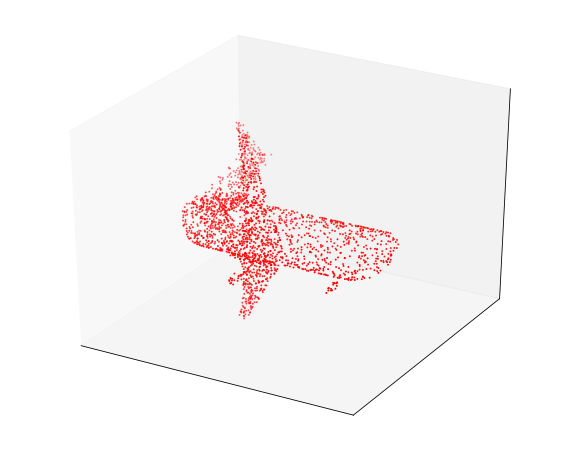

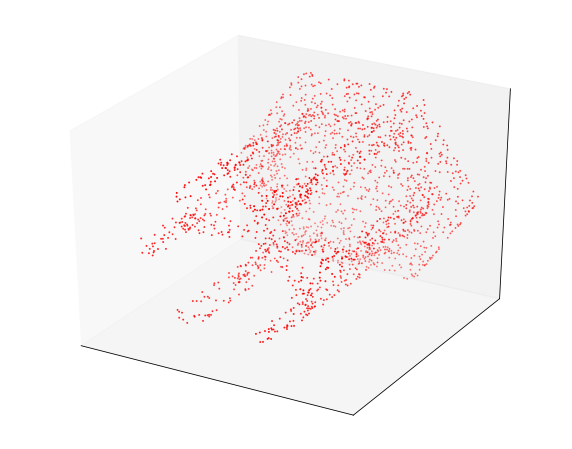

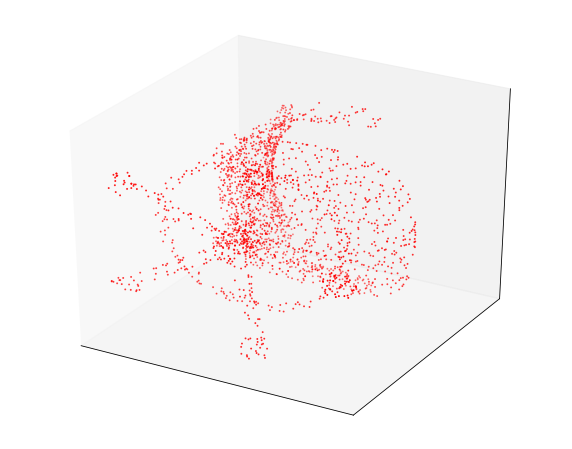

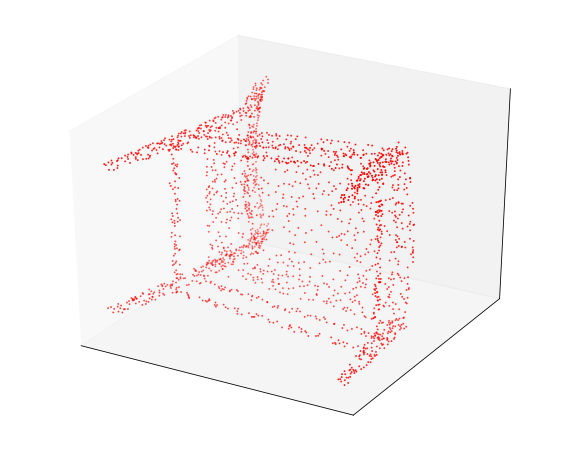

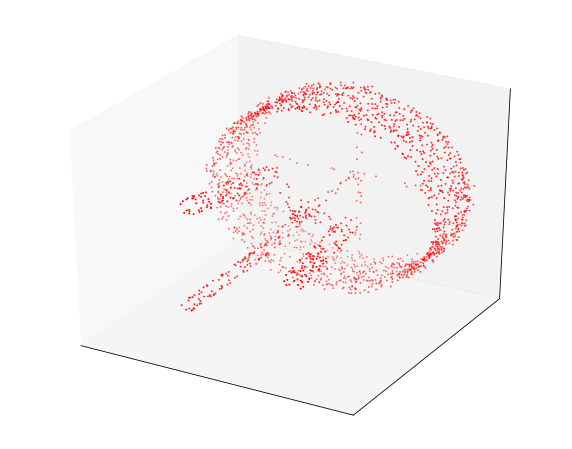

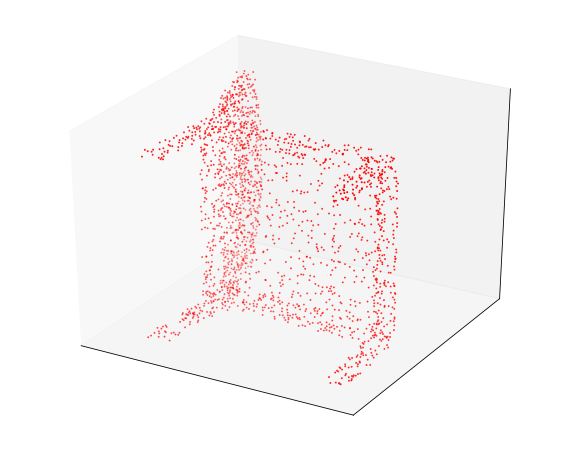

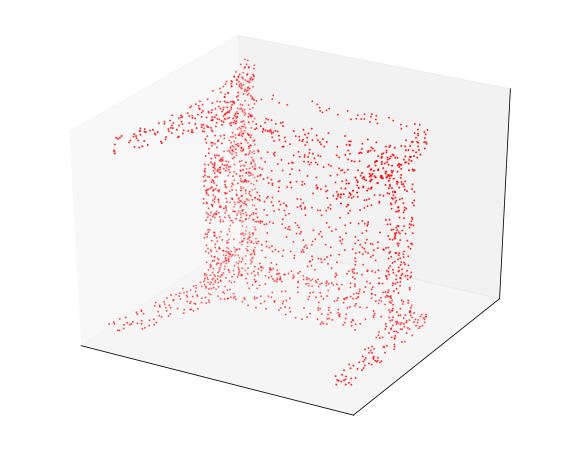

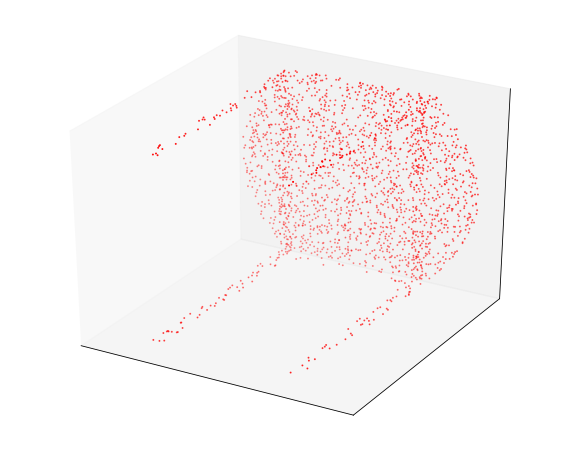

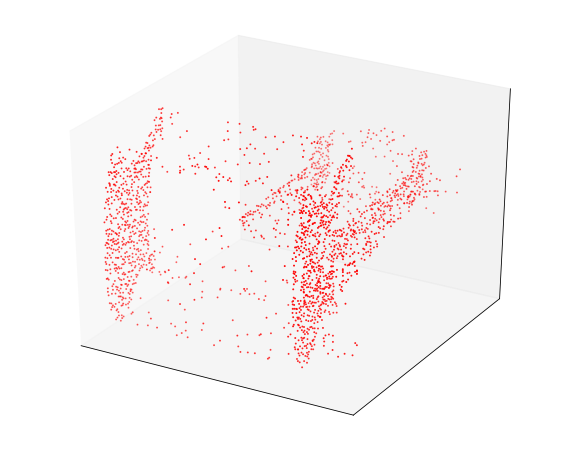

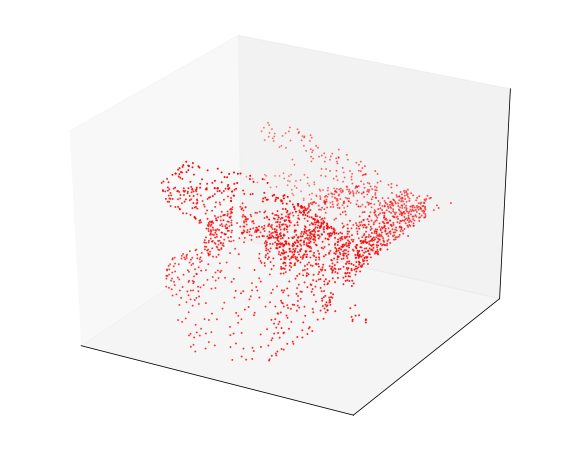

In [27]:
for i in range(10):
    visualize_npy(pn_train_data[i], save_img_fpath=None)

In [28]:
pn_train_ds = PointDriftDS(pn_train_data, pn_train_labels)
pn_test_ds  = PointDriftDS(pn_test_data, pn_test_labels)

##  Full PointNet data used for testing and training

### Load full PointNet data

In [29]:
pn_train_full        = np.load("./data/PointNetData/train/pntcloud_full.npy")
pn_train_full_labels = np.load("./data/PointNetData/train/label_full.npy")
pn_test_full         = np.load("./data/PointNetData/test/pntcloud_full.npy")
pn_test_full_labels  = np.load("./data/PointNetData/test/label_full.npy")
pn_train_full.shape, pn_train_full_labels.shape, pn_test_full.shape, pn_test_full_labels.shape

((12137, 2048, 3), (12137, 1), (2874, 2048, 3), (2874, 1))

### Single CompNet Training on the Full PointNet Data

In [30]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
fpn_train_ds = PointDriftDS(pn_train_full, pn_train_full_labels)
fpn_test_ds = PointDriftDS(pn_test_full, pn_test_full_labels)

# train autodecoder
fpn_autodecoder = train_decoder(adnet_HP, DS, 
                                train_ds=fpn_train_ds, test_ds=fpn_test_ds,
                                save_wt_fname='full_pnet_decoder.pth')

# get the train encodings
ftrain_encoding_ds = EncodingDS(PointDriftDS(
    pn_train_full, pn_train_full_labels), fpn_autodecoder)
ftrain_result = ftrain_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

# get the test encodings
ftest_encoding_ds = EncodingDS(PointDriftDS(
    pn_test_full, pn_test_full_labels), fpn_autodecoder)
ftest_result = ftest_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

# train the compnet
cpnet_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)
fcompnet1 = train_compnet(
    cpnet_HP, DS,
    train_ds=ftrain_encoding_ds, test_ds=ftest_encoding_ds,
    save_wt_fname='full_pnet_compnet.pth')

Epoch: 0. batch_idx: 100
Loss:  0.025587299950420857 0.07737211469560862
Epoch: 0. batch_idx: 200
Loss:  0.026243421137332915 0.07127915281802416
Epoch: 0. batch_idx: 300
Loss:  0.025857271198183297 0.06876975003629923
0 0.02562826 tensor(7.1048, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060885552 tensor(6.9757, device='cuda:0', grad_fn=<NormBackward0>)
0 0.023679791 tensor(7.0674, device='cuda:0', grad_fn=<NormBackward0>)
0 0.072779104 tensor(6.9833, device='cuda:0', grad_fn=<NormBackward0>)
0 0.023117961 tensor(7.2135, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06794218 tensor(7.1270, device='cuda:0', grad_fn=<NormBackward0>)
0 0.024606239 tensor(7.1677, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06817971 tensor(7.0929, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03431118 tensor(7.1640, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07176138 tensor(7.1282, device='cuda:0', grad_fn=<NormBackward0>)
0 0.024670118 tensor(7.1576, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0

0 0.024432061 tensor(7.2070, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06491942 tensor(7.1041, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028084183 tensor(7.2450, device='cuda:0', grad_fn=<NormBackward0>)
0 0.063718505 tensor(7.1154, device='cuda:0', grad_fn=<NormBackward0>)
0 0.024453238 tensor(7.1335, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06291061 tensor(7.1798, device='cuda:0', grad_fn=<NormBackward0>)
0 0.021593396 tensor(7.0687, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07523093 tensor(7.0770, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028502133 tensor(7.2063, device='cuda:0', grad_fn=<NormBackward0>)
0 0.067372575 tensor(7.0423, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030723102 tensor(7.1879, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07817427 tensor(7.0747, device='cuda:0', grad_fn=<NormBackward0>)
0 0.020786045 tensor(7.0593, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06399941 tensor(7.0724, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0279342

0 0.035308875 tensor(4.9911, device='cuda:0', grad_fn=<NormBackward0>)
0 0.058522098 tensor(5.0690, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03669474 tensor(5.0485, device='cuda:0', grad_fn=<NormBackward0>)
0 0.059190825 tensor(5.0649, device='cuda:0', grad_fn=<NormBackward0>)
0 0.042473067 tensor(5.0314, device='cuda:0', grad_fn=<NormBackward0>)
0 0.075616136 tensor(5.0966, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034607675 tensor(4.9894, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05825206 tensor(5.0538, device='cuda:0', grad_fn=<NormBackward0>)
0 0.044766445 tensor(4.9551, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06368875 tensor(5.0617, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02806235 tensor(5.0532, device='cuda:0', grad_fn=<NormBackward0>)
0 0.066326 tensor(5.0550, device='cuda:0', grad_fn=<NormBackward0>)
0 0.039186854 tensor(5.0599, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051253177 tensor(5.0338, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036290012

0 0.036921714 tensor(4.9895, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057762794 tensor(5.0807, device='cuda:0', grad_fn=<NormBackward0>)
0 0.046138212 tensor(5.0906, device='cuda:0', grad_fn=<NormBackward0>)
0 0.059651732 tensor(5.1143, device='cuda:0', grad_fn=<NormBackward0>)
0 0.054422673 tensor(5.0585, device='cuda:0', grad_fn=<NormBackward0>)
0 0.058798615 tensor(5.1064, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028563933 tensor(5.0499, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050692804 tensor(4.9975, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03005123 tensor(5.0629, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07382274 tensor(5.0692, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027618162 tensor(5.1360, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06152156 tensor(5.1109, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04594959 tensor(5.0580, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0584875 tensor(5.0510, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03311150

0 0.037089646 tensor(5.0712, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06519849 tensor(5.0159, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025347305 tensor(5.0925, device='cuda:0', grad_fn=<NormBackward0>)
0 0.064800635 tensor(5.0426, device='cuda:0', grad_fn=<NormBackward0>)
0 0.039985705 tensor(5.0706, device='cuda:0', grad_fn=<NormBackward0>)
0 0.053596724 tensor(5.0450, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031098217 tensor(5.0078, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04632672 tensor(5.0631, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04363751 tensor(5.0003, device='cuda:0', grad_fn=<NormBackward0>)
0 0.052082647 tensor(5.1079, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03332892 tensor(5.0596, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06160218 tensor(5.0763, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035644464 tensor(5.0199, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07742109 tensor(4.9734, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02403747

0 0.038259458 tensor(5.0575, device='cuda:0', grad_fn=<NormBackward0>)
0 0.056160968 tensor(5.0423, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037609614 tensor(4.9449, device='cuda:0', grad_fn=<NormBackward0>)
0 0.074478224 tensor(5.0473, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03850208 tensor(4.9131, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05292351 tensor(5.0063, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030147798 tensor(4.9928, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08649666 tensor(5.0936, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03261811 tensor(4.9651, device='cuda:0', grad_fn=<NormBackward0>)
0 0.084606335 tensor(5.0731, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025095105 tensor(5.1890, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08241634 tensor(5.0851, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028785074 tensor(4.9578, device='cuda:0', grad_fn=<NormBackward0>)
0 0.061383013 tensor(5.0108, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0402334

0 0.027451785 tensor(5.0420, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07103478 tensor(5.0999, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031582203 tensor(5.0975, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057226054 tensor(5.0016, device='cuda:0', grad_fn=<NormBackward0>)
0 0.043126147 tensor(5.1030, device='cuda:0', grad_fn=<NormBackward0>)
0 0.072828546 tensor(5.0833, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030692259 tensor(5.0782, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05647306 tensor(4.9220, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029065408 tensor(5.0457, device='cuda:0', grad_fn=<NormBackward0>)
0 0.076332785 tensor(4.9516, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035290617 tensor(5.0334, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050543588 tensor(5.0664, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026096528 tensor(5.0236, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06056098 tensor(5.0073, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02960

0 0.053760912 tensor(5.1010, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057664383 tensor(5.0820, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031236984 tensor(5.0993, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0670048 tensor(5.1546, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0246456 tensor(5.0832, device='cuda:0', grad_fn=<NormBackward0>)
0 0.055986937 tensor(5.0313, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029811287 tensor(4.9856, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07062675 tensor(4.9972, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037311926 tensor(5.0037, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0628517 tensor(5.0443, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031731132 tensor(5.0049, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06867208 tensor(5.0578, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027725184 tensor(5.0058, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060906418 tensor(5.1315, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051328372 

0 0.037386503 tensor(4.9774, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06245579 tensor(5.0475, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02588737 tensor(5.0410, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0488946 tensor(5.0432, device='cuda:0', grad_fn=<NormBackward0>)
0 0.046365485 tensor(5.0808, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05258475 tensor(5.0194, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036845107 tensor(5.0159, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07452365 tensor(5.0400, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030756975 tensor(5.0625, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06043421 tensor(5.0911, device='cuda:0', grad_fn=<NormBackward0>)
0 0.040843826 tensor(5.1301, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08295797 tensor(5.0325, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036470108 tensor(5.0509, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08326289 tensor(4.9631, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05031831 te

0 0.04296235 tensor(5.0723, device='cuda:0', grad_fn=<NormBackward0>)
0 0.053648848 tensor(5.0569, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030526618 tensor(4.9383, device='cuda:0', grad_fn=<NormBackward0>)
0 0.065249786 tensor(5.0657, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027506433 tensor(5.0041, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06835233 tensor(5.0298, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03178952 tensor(5.0517, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06659095 tensor(4.9682, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034072112 tensor(4.9985, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07143125 tensor(5.0032, device='cuda:0', grad_fn=<NormBackward0>)
0 0.038347967 tensor(5.0021, device='cuda:0', grad_fn=<NormBackward0>)
0 0.067380086 tensor(4.9813, device='cuda:0', grad_fn=<NormBackward0>)
0 0.022421725 tensor(5.0764, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06506246 tensor(5.0934, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03597542

0 0.033162158 tensor(5.0381, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07112101 tensor(5.1161, device='cuda:0', grad_fn=<NormBackward0>)
0 0.043509718 tensor(5.0017, device='cuda:0', grad_fn=<NormBackward0>)
0 0.048985656 tensor(5.0035, device='cuda:0', grad_fn=<NormBackward0>)
0 0.041568916 tensor(4.9405, device='cuda:0', grad_fn=<NormBackward0>)
0 0.064536706 tensor(5.0596, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025199912 tensor(5.1029, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07499567 tensor(4.9863, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036594212 tensor(5.0147, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051113144 tensor(5.0785, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025347842 tensor(4.9883, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06507072 tensor(5.0799, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030575734 tensor(5.0360, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05101709 tensor(5.0453, device='cuda:0', grad_fn=<NormBackward0>)
0 0.033804

0 0.037807763 tensor(5.1061, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07617874 tensor(5.1507, device='cuda:0', grad_fn=<NormBackward0>)
0 0.022595387 tensor(5.0716, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07928368 tensor(5.0092, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029734414 tensor(5.0974, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06701447 tensor(5.0353, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0354825 tensor(5.0218, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05656669 tensor(5.0281, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034659218 tensor(5.0567, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05292426 tensor(5.0691, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029635176 tensor(5.0048, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057649147 tensor(5.1335, device='cuda:0', grad_fn=<NormBackward0>)
0 0.044054963 tensor(4.9829, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06831767 tensor(5.0760, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02944737 t

0 0.025026804 tensor(4.9713, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057745334 tensor(4.9978, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026977774 tensor(4.9308, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060195945 tensor(5.0548, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03533968 tensor(5.0470, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06358066 tensor(5.0481, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030192483 tensor(5.0434, device='cuda:0', grad_fn=<NormBackward0>)
0 0.058333993 tensor(5.0543, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04166457 tensor(5.0410, device='cuda:0', grad_fn=<NormBackward0>)
0 0.049376458 tensor(5.0552, device='cuda:0', grad_fn=<NormBackward0>)
0 0.040123016 tensor(5.0228, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04288316 tensor(5.0991, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025786145 tensor(5.1344, device='cuda:0', grad_fn=<NormBackward0>)
0 0.068943866 tensor(5.0493, device='cuda:0', grad_fn=<NormBackward0>)
0 0.033337

0 0.039554056 tensor(4.9670, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07155287 tensor(5.0061, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026725948 tensor(5.1091, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04852303 tensor(5.1249, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031632133 tensor(5.0112, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06619873 tensor(5.0259, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025426878 tensor(5.0287, device='cuda:0', grad_fn=<NormBackward0>)
0 0.058218356 tensor(5.0350, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030818397 tensor(5.1184, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05124359 tensor(5.1767, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027125916 tensor(5.0283, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05087986 tensor(5.0705, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036785893 tensor(5.0192, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07897027 tensor(5.0147, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03294572

0 0.03930115 tensor(4.9977, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06263185 tensor(5.0090, device='cuda:0', grad_fn=<NormBackward0>)
0 0.024908016 tensor(4.9610, device='cuda:0', grad_fn=<NormBackward0>)
0 0.062363088 tensor(5.0301, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031319637 tensor(5.0266, device='cuda:0', grad_fn=<NormBackward0>)
0 0.047725327 tensor(5.0894, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02814106 tensor(4.9906, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06244455 tensor(5.1224, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026748942 tensor(5.0651, device='cuda:0', grad_fn=<NormBackward0>)
0 0.073326804 tensor(5.0895, device='cuda:0', grad_fn=<NormBackward0>)
0 0.039736897 tensor(5.1025, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04872357 tensor(5.0551, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037597734 tensor(5.0586, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04323539 tensor(5.0543, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03649418

0 0.029528877 tensor(4.9644, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04346436 tensor(5.0873, device='cuda:0', grad_fn=<NormBackward0>)
0 0.032936577 tensor(5.0132, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06897152 tensor(5.0535, device='cuda:0', grad_fn=<NormBackward0>)
0 0.056332342 tensor(5.0716, device='cuda:0', grad_fn=<NormBackward0>)
0 0.085186124 tensor(4.9943, device='cuda:0', grad_fn=<NormBackward0>)
0 0.043419152 tensor(5.0705, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060273603 tensor(5.1075, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029514117 tensor(5.0537, device='cuda:0', grad_fn=<NormBackward0>)
0 0.056512684 tensor(5.0542, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031230522 tensor(5.0766, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06423494 tensor(4.9856, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031966485 tensor(5.0448, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06612615 tensor(5.1044, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031401

0 0.046386503 tensor(5.0260, device='cuda:0', grad_fn=<NormBackward0>)
0 0.058827285 tensor(4.9829, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028507456 tensor(5.0373, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0705741 tensor(4.9724, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035763584 tensor(4.9978, device='cuda:0', grad_fn=<NormBackward0>)
0 0.059058663 tensor(5.0547, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034950715 tensor(4.9079, device='cuda:0', grad_fn=<NormBackward0>)
0 0.061061874 tensor(5.1327, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029560385 tensor(5.0160, device='cuda:0', grad_fn=<NormBackward0>)
0 0.054170065 tensor(5.0821, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034880273 tensor(5.0965, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07543439 tensor(4.9737, device='cuda:0', grad_fn=<NormBackward0>)
0 0.021950513 tensor(5.0363, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05540689 tensor(5.0787, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027670

0 0.030813789 tensor(4.9670, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05455894 tensor(5.1424, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03383531 tensor(5.0478, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08301808 tensor(4.9818, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037864514 tensor(5.0739, device='cuda:0', grad_fn=<NormBackward0>)
0 0.065808356 tensor(5.0501, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027819939 tensor(4.9775, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07767491 tensor(5.0276, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025334941 tensor(5.0111, device='cuda:0', grad_fn=<NormBackward0>)
0 0.055750947 tensor(5.0352, device='cuda:0', grad_fn=<NormBackward0>)
0 0.033619825 tensor(4.9805, device='cuda:0', grad_fn=<NormBackward0>)
0 0.047457024 tensor(4.9914, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028124908 tensor(5.0291, device='cuda:0', grad_fn=<NormBackward0>)
0 0.056286085 tensor(5.0442, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031309

Epoch: 5. batch_idx: 700
Loss:  0.26199734427034854 0.24803928505629302
------------------ Evaluation Report ------------------
Total Accuracy: 0.872999304105776
After 180 batches and 2874 test points

Metrics for the same class:
Avg loss: 0.35198693925307856
Precision: 0.8820384889522452
Recall: 0.8611691022964509
F1 Score: 0.8714788732394366

Metrics for the diff class:
Avg loss: 0.26900129280984403
Precision: 0.8643779741672332
Recall: 0.8848295059151009
F1 Score: 0.874484181568088
Eval:  (63.35764906555414, 48.42023270577192, 2475.0, 2543.0, 399.0, 331.0, 180, 2874)
Epoch: 6. batch_idx: 100
Loss:  0.25972499407827854 0.2569620044529438
Epoch: 6. batch_idx: 200
Loss:  0.25540134333074094 0.2537341108173132
Epoch: 6. batch_idx: 300
Loss:  0.2512501173466444 0.23759709719568492
Epoch: 6. batch_idx: 400
Loss:  0.2503745733201504 0.24944472424685954
Epoch: 6. batch_idx: 500
Loss:  0.25753523252904414 0.2489775688201189
Epoch: 6. batch_idx: 600
Loss:  0.2547546292468905 0.249539316408336

Epoch: 19. batch_idx: 300
Loss:  0.19493373392149807 0.18323098357766868
Epoch: 19. batch_idx: 400
Loss:  0.16641744604334235 0.17642379634082317
Epoch: 19. batch_idx: 500
Loss:  0.20943006981164217 0.2163612052425742
Epoch: 19. batch_idx: 600
Loss:  0.1992196250706911 0.1863396381959319
Epoch: 19. batch_idx: 700
Loss:  0.21021469010040164 0.18134408969432114


### Single CompNet Result on Full PointNet

In [31]:
# evaluate compnet
eval_compnet(fcompnet1, ftest_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.8731732776617954
After 180 batches and 2874 test points

Metrics for the same class:
Avg loss: 0.345928074626459
Precision: 0.8772423496306718
Recall: 0.8677800974251914
F1 Score: 0.8724855693545567

Metrics for the diff class:
Avg loss: 0.29122032361725964
Precision: 0.8691910499139415
Recall: 0.8785664578983995
F1 Score: 0.8738536078906385


(62.26705343276262, 52.41965825110674, 2494.0, 2525.0, 380.0, 349.0, 180, 2874)

### Train the Ensemble CompNets on Full PointNet

In [33]:
ensemble_HP = HyperParameter(lr=0.001, batch_size=16)

# Train with the ensemble net
fensemble1 = train_compnet(ensemble_HP, DS,
                           train_ds=ftrain_encoding_ds,
                           test_ds=ftest_encoding_ds,
                           compnet=EnsembleCompNet(),
                           save_wt_fname='full_pnet_ensemble1.pth')

Epoch: 0. batch_idx: 100
Loss:  0.8218743902444839 0.5916061848402023
Epoch: 0. batch_idx: 200
Loss:  0.6989821815490722 0.6778751915693283
Epoch: 0. batch_idx: 300
Loss:  0.5556294327974319 0.7489357119798661
Epoch: 0. batch_idx: 400
Loss:  0.40664244562387464 0.6999110072851181
Epoch: 0. batch_idx: 500
Loss:  0.31241865307092664 0.6144248044490814
Epoch: 0. batch_idx: 600
Loss:  0.26526329696178436 0.5457799485325814
Epoch: 0. batch_idx: 700
Loss:  0.21548073790967465 0.5099008363485337
------------------ Evaluation Report ------------------
Total Accuracy: 0.947286012526096
After 180 batches and 2874 test points

Metrics for the same class:
Avg loss: 0.2033627378443877
Precision: 0.9150791088149822
Recall: 0.9860821155184412
F1 Score: 0.9492547312008038

Metrics for the diff class:
Avg loss: 0.45523734307951397
Precision: 0.98491135420596
Recall: 0.9084899095337509
F1 Score: 0.945158371040724
Eval:  (36.605292811989784, 81.94272175431252, 2834.0, 2611.0, 40.0, 263.0, 180, 2874)
Epoc

### Ensemble CompNet results on Full PointNet

In [34]:
eval_compnet(fensemble1, ftest_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.9867780097425192
After 180 batches and 2874 test points

Metrics for the same class:
Avg loss: 0.07112584906733699
Precision: 0.9857638888888889
Recall: 0.9878218510786361
F1 Score: 0.9867917970107751

Metrics for the diff class:
Avg loss: 0.1575459154529704
Precision: 0.9877963737796374
Recall: 0.9857341684064023
F1 Score: 0.9867641936607454


(12.802652832120657, 28.358264781534672, 2839.0, 2833.0, 35.0, 41.0, 180, 2874)

________

# Training and Testing different models on the PointNet 7 Data

## Train AutoDecoder

**Note:** Training takes a while

In [35]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
adnet_HP

l2_reg: None
learning_rate: 0.001
encoding_size: 256
encoding_iters: 50
num_point_cloud: 3
epochs: 4
batch_size: 32

In [36]:
pn_autodecoder = None
load_saved_weight = True

if load_saved_weight:
    try:
        pn_load_adnet = AutoDecoder(HP.encoding_size, HP.num_point_cloud)
        pn_load_adnet.load_state_dict(torch.load(DS.AUTODECODER_TRAINED_WEIGHT_DIR+'/pnet_decoder.pth'))
        print('Loaded decoder saved weights from', DS.AUTODECODER_TRAINED_WEIGHT_DIR+'/pnet_decoder.pth')
        pn_autodecoder = train_decoder(adnet_HP, DS, 
                                       train_ds=pn_train_ds, test_ds=pn_test_ds, 
                                       decoder=pn_load_adnet, save_wt_fname='pnet_decoder.pth')
    except (RuntimeError,FileNotFoundError) as e:
        print(e)
        pn_autodecoder = train_decoder(adnet_HP, DS, 
                                       train_ds=pn_train_ds, test_ds=pn_test_ds, 
                                       save_wt_fname='pnet_decoder.pth')
else:
    print("Training a new Decoder")
    pn_autodecoder = train_decoder(adnet_HP, DS, 
                                   train_ds=pn_train_ds, test_ds=pn_test_ds, 
                                   save_wt_fname='pnet_decoder.pth')

[Errno 2] No such file or directory: './autodecoder_trained_weights/pnet_decoder.pth'
Epoch: 0. batch_idx: 100
Loss:  0.02794767202809453 0.07389392904937267
Epoch: 0. batch_idx: 200
Loss:  0.026540347617119552 0.06701051950454712
Epoch: 0. batch_idx: 300
Loss:  0.02773199772462249 0.06504520639777184
0 0.024613507 tensor(7.1907, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06477843 tensor(7.1196, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029409401 tensor(7.1250, device='cuda:0', grad_fn=<NormBackward0>)
0 0.062493756 tensor(7.0302, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029601006 tensor(7.1585, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06645435 tensor(7.1386, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025445601 tensor(7.1864, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07293329 tensor(7.1410, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028621877 tensor(7.0345, device='cuda:0', grad_fn=<NormBackward0>)
0 0.072253086 tensor(7.0152, device='cuda:0', grad_fn=<NormBa

0 0.029016534 tensor(7.1970, device='cuda:0', grad_fn=<NormBackward0>)
0 0.069034144 tensor(7.0258, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03001567 tensor(7.1231, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05720359 tensor(7.1062, device='cuda:0', grad_fn=<NormBackward0>)
0 0.040428523 tensor(7.1022, device='cuda:0', grad_fn=<NormBackward0>)
0 0.061212387 tensor(7.0499, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03402654 tensor(7.0310, device='cuda:0', grad_fn=<NormBackward0>)
0 0.076049946 tensor(7.1373, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034385566 tensor(7.0818, device='cuda:0', grad_fn=<NormBackward0>)
0 0.065968886 tensor(7.0757, device='cuda:0', grad_fn=<NormBackward0>)
0 0.025138408 tensor(7.1378, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05141277 tensor(7.1120, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030398244 tensor(7.0892, device='cuda:0', grad_fn=<NormBackward0>)
0 0.062481612 tensor(7.1306, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034185

In [37]:
""" Get memory usage of active variables """
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('pn_train_full', 298279040),
 ('pn_train_data', 265838720),
 ('pn_test_full', 70631552),
 ('pn_test_data', 61612160),
 ('pn_train_full_labels', 12249),
 ('pn_train_labels', 10929),
 ('pn_test_full_labels', 2986),
 ('pn_test_labels', 2619),
 ('DataLoader', 1464),
 ('AutoDecoder', 1184),
 ('CompNet', 1184),
 ('EnsembleCompNet', 1184),
 ('HyperParameter', 1184),
 ('Dataset', 1056),
 ('DirectorySetting', 1056),
 ('EncodingDS', 1056),
 ('GaussianNB', 1056),
 ('LogisticRegression', 1056),
 ('PointDriftDS', 1056),
 ('PointNetDS', 1056),
 ('RBFSampler', 1056),
 ('RandomForestClassifier', 1056),
 ('SGDClassifier', 1056),
 ('Variable', 1056),
 ('chamfer_loss', 136),
 ('classify', 136),
 ('eval_compnet', 136),
 ('eval_decision_trees', 136),
 ('eval_decoder', 136),
 ('eval_gaussian_naive_bayes', 136),
 ('eval_log_regr', 136),
 ('eval_rand_forest', 136),
 ('eval_svm', 136),
 ('find_encoding', 136),
 ('generate_class_samples', 136),
 ('hinge_loss', 136),
 ('log_loss', 136),
 ('print_model_metrics'

In [38]:
# Evaluate Decoder
print(eval_decoder(pn_autodecoder, pn_test_ds))

0 0.029734096 tensor(5.0638, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060451668 tensor(5.1207, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04765228 tensor(5.0070, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06550624 tensor(5.0419, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02990359 tensor(5.1180, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06373145 tensor(5.0454, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04157687 tensor(5.0910, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051320557 tensor(5.0774, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030782016 tensor(5.0358, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07671048 tensor(5.0445, device='cuda:0', grad_fn=<NormBackward0>)
0 0.048179895 tensor(5.0758, device='cuda:0', grad_fn=<NormBackward0>)
0 0.064507395 tensor(5.0808, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02700927 tensor(5.0550, device='cuda:0', grad_fn=<NormBackward0>)
0 0.053784885 tensor(5.1243, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035347972

0 0.07602666 tensor(5.0616, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031505413 tensor(5.0300, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060485516 tensor(5.0138, device='cuda:0', grad_fn=<NormBackward0>)
0 0.039792974 tensor(4.8895, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06391544 tensor(5.0459, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03034714 tensor(5.0619, device='cuda:0', grad_fn=<NormBackward0>)
0 0.068458185 tensor(5.0762, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03342396 tensor(5.0249, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060749337 tensor(5.1085, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028345764 tensor(4.9771, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06515968 tensor(5.0279, device='cuda:0', grad_fn=<NormBackward0>)
0 0.053416982 tensor(5.0085, device='cuda:0', grad_fn=<NormBackward0>)
0 0.064542785 tensor(5.0691, device='cuda:0', grad_fn=<NormBackward0>)
0 0.033583283 tensor(5.0990, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0681080

0 0.02239422 tensor(5.1345, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06464474 tensor(5.1050, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05044693 tensor(5.0256, device='cuda:0', grad_fn=<NormBackward0>)
0 0.075173944 tensor(5.0594, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034872286 tensor(4.9459, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05106547 tensor(5.0925, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04761474 tensor(4.9653, device='cuda:0', grad_fn=<NormBackward0>)
0 0.077581264 tensor(5.0051, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036646757 tensor(5.1217, device='cuda:0', grad_fn=<NormBackward0>)
0 0.045887366 tensor(4.9561, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03014954 tensor(5.0166, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06048067 tensor(5.0729, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034125786 tensor(4.9949, device='cuda:0', grad_fn=<NormBackward0>)
0 0.079068825 tensor(5.0213, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03886349 

## Encode pairs in dataset and train Encodings with trained AutoDecoders

In [39]:
train_encoding_ds = EncodingDS(PointDriftDS(pn_train_data, pn_train_labels), pn_autodecoder)
train_result = train_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

0 0.027097732 tensor(5.0938, device='cuda:0', grad_fn=<NormBackward0>)
0 0.048069805 tensor(5.0805, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031687066 tensor(5.1356, device='cuda:0', grad_fn=<NormBackward0>)
0 0.056861542 tensor(5.1011, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0322587 tensor(5.1370, device='cuda:0', grad_fn=<NormBackward0>)
0 0.061527226 tensor(5.1394, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026587365 tensor(5.1126, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05678746 tensor(5.0657, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028479561 tensor(5.0075, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05903308 tensor(4.9718, device='cuda:0', grad_fn=<NormBackward0>)
0 0.043350756 tensor(5.0211, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05900556 tensor(4.9913, device='cuda:0', grad_fn=<NormBackward0>)
0 0.024689443 tensor(5.0691, device='cuda:0', grad_fn=<NormBackward0>)
0 0.052640833 tensor(5.0977, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0411367

0 0.032797962 tensor(5.0548, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05395709 tensor(5.0274, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035661034 tensor(5.0797, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06268931 tensor(5.1387, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027921986 tensor(4.9844, device='cuda:0', grad_fn=<NormBackward0>)
0 0.052547466 tensor(5.0471, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0337366 tensor(5.0683, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05734548 tensor(5.0305, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03806551 tensor(5.0745, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050882198 tensor(5.0632, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027177434 tensor(5.0224, device='cuda:0', grad_fn=<NormBackward0>)
0 0.045401834 tensor(5.0221, device='cuda:0', grad_fn=<NormBackward0>)
0 0.045709364 tensor(5.0687, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05917336 tensor(5.0213, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02757898 

0 0.032306522 tensor(5.0390, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05933342 tensor(5.1198, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028157096 tensor(5.0327, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05417556 tensor(5.0386, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029286012 tensor(5.0916, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057126917 tensor(5.0127, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03125827 tensor(4.9833, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04802631 tensor(5.0202, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035169337 tensor(5.1030, device='cuda:0', grad_fn=<NormBackward0>)
0 0.081037395 tensor(5.0982, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04090755 tensor(5.0694, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06763881 tensor(5.0646, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03140786 tensor(5.0715, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05665443 tensor(5.0039, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028303437 

0 0.03874177 tensor(5.0050, device='cuda:0', grad_fn=<NormBackward0>)
0 0.068252794 tensor(5.0228, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037428018 tensor(5.0174, device='cuda:0', grad_fn=<NormBackward0>)
0 0.052273482 tensor(5.0233, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029741477 tensor(5.0204, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07417237 tensor(4.9241, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04487673 tensor(4.9740, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050731707 tensor(5.0994, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030771954 tensor(5.1072, device='cuda:0', grad_fn=<NormBackward0>)
0 0.052424856 tensor(5.1142, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035283517 tensor(5.0658, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08482748 tensor(5.0387, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036132608 tensor(5.0681, device='cuda:0', grad_fn=<NormBackward0>)
0 0.058171496 tensor(5.1914, device='cuda:0', grad_fn=<NormBackward0>)
0 0.038954

0 0.037812725 tensor(5.0530, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050737116 tensor(4.9797, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029223617 tensor(5.0735, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050768293 tensor(5.0939, device='cuda:0', grad_fn=<NormBackward0>)
0 0.038195577 tensor(4.9733, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05559676 tensor(5.0761, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034372654 tensor(5.0616, device='cuda:0', grad_fn=<NormBackward0>)
0 0.062451888 tensor(5.1164, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026910534 tensor(5.0463, device='cuda:0', grad_fn=<NormBackward0>)
0 0.045865253 tensor(5.0553, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037577145 tensor(4.9208, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06101209 tensor(5.0875, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05547421 tensor(5.0769, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04845406 tensor(5.0497, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029264

0 0.025452146 tensor(5.0512, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08047898 tensor(5.0218, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036450606 tensor(4.9875, device='cuda:0', grad_fn=<NormBackward0>)
0 0.071472704 tensor(5.0156, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036700696 tensor(5.0050, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07028777 tensor(5.0826, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0393324 tensor(5.0207, device='cuda:0', grad_fn=<NormBackward0>)
0 0.054047324 tensor(4.9837, device='cuda:0', grad_fn=<NormBackward0>)
0 0.043324348 tensor(4.9843, device='cuda:0', grad_fn=<NormBackward0>)
0 0.049250595 tensor(5.0991, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027325364 tensor(5.1105, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06765679 tensor(5.1167, device='cuda:0', grad_fn=<NormBackward0>)
0 0.047722243 tensor(4.9985, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05488573 tensor(5.1144, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03280836

0 0.031144887 tensor(4.9602, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05748149 tensor(5.0551, device='cuda:0', grad_fn=<NormBackward0>)
0 0.053748358 tensor(4.9734, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05443019 tensor(5.0171, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030204108 tensor(5.1161, device='cuda:0', grad_fn=<NormBackward0>)
0 0.08257969 tensor(5.0289, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03217202 tensor(5.1379, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0470375 tensor(5.0565, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031283684 tensor(5.0985, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06406216 tensor(5.0403, device='cuda:0', grad_fn=<NormBackward0>)
0 0.041683603 tensor(5.0238, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06471695 tensor(5.0909, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027575525 tensor(5.1543, device='cuda:0', grad_fn=<NormBackward0>)
0 0.045144293 tensor(5.1021, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030204168 

0 0.036482587 tensor(5.0389, device='cuda:0', grad_fn=<NormBackward0>)
0 0.059805885 tensor(5.0622, device='cuda:0', grad_fn=<NormBackward0>)
0 0.042406734 tensor(4.9775, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07881319 tensor(5.0166, device='cuda:0', grad_fn=<NormBackward0>)
0 0.042241395 tensor(4.9648, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06639522 tensor(5.1091, device='cuda:0', grad_fn=<NormBackward0>)
0 0.044517145 tensor(4.9938, device='cuda:0', grad_fn=<NormBackward0>)
0 0.075627185 tensor(5.0776, device='cuda:0', grad_fn=<NormBackward0>)
0 0.022916378 tensor(5.0125, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050936352 tensor(5.1421, device='cuda:0', grad_fn=<NormBackward0>)
0 0.027598446 tensor(5.0124, device='cuda:0', grad_fn=<NormBackward0>)
0 0.054495085 tensor(5.0370, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03445975 tensor(5.0446, device='cuda:0', grad_fn=<NormBackward0>)
0 0.064370275 tensor(4.9909, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03170

0 0.031462707 tensor(5.0508, device='cuda:0', grad_fn=<NormBackward0>)
0 0.050541453 tensor(5.0147, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026892357 tensor(5.0041, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07125583 tensor(5.0259, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036821365 tensor(5.0982, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05494305 tensor(5.1416, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05477442 tensor(5.1653, device='cuda:0', grad_fn=<NormBackward0>)
0 0.055036046 tensor(5.0610, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03863922 tensor(5.0401, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04779403 tensor(5.0205, device='cuda:0', grad_fn=<NormBackward0>)
0 0.036045358 tensor(4.9979, device='cuda:0', grad_fn=<NormBackward0>)
0 0.055888057 tensor(4.9712, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04374347 tensor(5.0794, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04999098 tensor(4.9856, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03520633 

0 0.044976454 tensor(5.0737, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06256062 tensor(4.9761, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05579948 tensor(4.9621, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060272966 tensor(5.0621, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026609477 tensor(5.1144, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05654065 tensor(5.0047, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03320316 tensor(4.9894, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05395332 tensor(5.0998, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04419033 tensor(5.0239, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07764652 tensor(5.0751, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04453565 tensor(5.0977, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051233657 tensor(5.0396, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051172398 tensor(4.9830, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06913472 tensor(5.0535, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030074598 t

0 0.02887904 tensor(5.1741, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057035778 tensor(5.0001, device='cuda:0', grad_fn=<NormBackward0>)
0 0.026527165 tensor(5.0093, device='cuda:0', grad_fn=<NormBackward0>)
0 0.041396543 tensor(5.0840, device='cuda:0', grad_fn=<NormBackward0>)
0 0.032779187 tensor(5.0741, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0600757 tensor(5.0316, device='cuda:0', grad_fn=<NormBackward0>)
0 0.044463202 tensor(5.0418, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05008789 tensor(4.9908, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028377695 tensor(4.9361, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05532261 tensor(5.0254, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029783491 tensor(5.0567, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04614973 tensor(5.0691, device='cuda:0', grad_fn=<NormBackward0>)
0 0.040039245 tensor(4.9859, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04890931 tensor(5.0606, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03275507 

0 0.022061642 tensor(5.1814, device='cuda:0', grad_fn=<NormBackward0>)
0 0.063917 tensor(4.9675, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04180534 tensor(4.9525, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06302408 tensor(5.0796, device='cuda:0', grad_fn=<NormBackward0>)
0 0.028159805 tensor(5.0008, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05115377 tensor(5.0521, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04029742 tensor(4.9373, device='cuda:0', grad_fn=<NormBackward0>)
0 0.059833817 tensor(5.0972, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030895352 tensor(4.9721, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06245937 tensor(5.1355, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029393384 tensor(5.0945, device='cuda:0', grad_fn=<NormBackward0>)
0 0.048989855 tensor(5.0697, device='cuda:0', grad_fn=<NormBackward0>)
0 0.032518517 tensor(5.0934, device='cuda:0', grad_fn=<NormBackward0>)
0 0.051442157 tensor(5.1195, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0409532 te

In [40]:
test_encoding_ds = EncodingDS(PointDriftDS(pn_test_data, pn_test_labels), pn_autodecoder)
test_result = test_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

0 0.027995616 tensor(4.9835, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057383962 tensor(5.0866, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034174327 tensor(4.9647, device='cuda:0', grad_fn=<NormBackward0>)
0 0.067244545 tensor(5.0196, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037006337 tensor(4.9247, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05775417 tensor(5.0902, device='cuda:0', grad_fn=<NormBackward0>)
0 0.024789557 tensor(5.0512, device='cuda:0', grad_fn=<NormBackward0>)
0 0.060619604 tensor(5.1496, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037993554 tensor(5.0409, device='cuda:0', grad_fn=<NormBackward0>)
0 0.065743394 tensor(5.0774, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05283339 tensor(4.9774, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06745849 tensor(5.0123, device='cuda:0', grad_fn=<NormBackward0>)
0 0.033783264 tensor(5.0870, device='cuda:0', grad_fn=<NormBackward0>)
0 0.044950593 tensor(5.0767, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03073

0 0.048392747 tensor(5.0500, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03658919 tensor(5.0345, device='cuda:0', grad_fn=<NormBackward0>)
0 0.061956905 tensor(5.0967, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03192659 tensor(5.0899, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05448073 tensor(5.1528, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02910586 tensor(5.0348, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07969791 tensor(5.0840, device='cuda:0', grad_fn=<NormBackward0>)
0 0.02773162 tensor(4.9524, device='cuda:0', grad_fn=<NormBackward0>)
0 0.06479793 tensor(5.0403, device='cuda:0', grad_fn=<NormBackward0>)
0 0.035521183 tensor(4.9903, device='cuda:0', grad_fn=<NormBackward0>)
0 0.061347388 tensor(5.0800, device='cuda:0', grad_fn=<NormBackward0>)
0 0.03422879 tensor(4.9885, device='cuda:0', grad_fn=<NormBackward0>)
0 0.05354318 tensor(5.0132, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04784313 tensor(5.0338, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07380415 ten

0 0.04119025 tensor(5.0203, device='cuda:0', grad_fn=<NormBackward0>)
0 0.037898265 tensor(5.1433, device='cuda:0', grad_fn=<NormBackward0>)
0 0.031646952 tensor(5.0781, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04315282 tensor(5.1076, device='cuda:0', grad_fn=<NormBackward0>)
0 0.048994888 tensor(5.0697, device='cuda:0', grad_fn=<NormBackward0>)
0 0.04944562 tensor(4.9258, device='cuda:0', grad_fn=<NormBackward0>)
0 0.030706769 tensor(4.9232, device='cuda:0', grad_fn=<NormBackward0>)
0 0.057806008 tensor(5.0988, device='cuda:0', grad_fn=<NormBackward0>)
0 0.034708377 tensor(4.9361, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07837986 tensor(5.1295, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029547354 tensor(4.9585, device='cuda:0', grad_fn=<NormBackward0>)
0 0.052459635 tensor(5.0664, device='cuda:0', grad_fn=<NormBackward0>)
0 0.029494608 tensor(5.0110, device='cuda:0', grad_fn=<NormBackward0>)
0 0.07554464 tensor(5.1279, device='cuda:0', grad_fn=<NormBackward0>)
0 0.0331683

## Train a single CompNet on the PointNet7 Data

In [41]:
cpnet_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)

In [42]:
compnet1 = train_compnet(cpnet_HP, DS, 
                         train_ds=train_encoding_ds,
                         test_ds=test_encoding_ds,
                         save_wt_fname='pnet_compnet.pth')

Epoch: 0. batch_idx: 100
Loss:  0.43719512403011324 0.661531791985035
Epoch: 0. batch_idx: 200
Loss:  0.39302008524537085 0.4197089682519436
Epoch: 0. batch_idx: 300
Loss:  0.4090387867391109 0.3783525288105011
Epoch: 0. batch_idx: 400
Loss:  0.3643462359160185 0.3506829060614109
Epoch: 0. batch_idx: 500
Loss:  0.381950771138072 0.3492050875723362
Epoch: 0. batch_idx: 600
Loss:  0.3707138511538506 0.3500819993019104
------------------ Evaluation Report ------------------
Total Accuracy: 0.8436378141204627
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.3829245588202385
Precision: 0.8492095662748277
Recall: 0.8356601515755884
F1 Score: 0.8423803779654202

Metrics for the diff class:
Avg loss: 0.340087541064639
Precision: 0.8382410679230468
Recall: 0.8516154766653371
F1 Score: 0.8448753462603877
Eval:  (60.11915573477745, 53.39374394714832, 2095.0, 2135.0, 412.0, 372.0, 157, 2507)
Epoch: 1. batch_idx: 100
Loss:  0.3493100728839636 0.33663756877183915
Epoch

Epoch: 15. batch_idx: 500
Loss:  0.22549942137673498 0.2153153133764863
Epoch: 15. batch_idx: 600
Loss:  0.22235794126987457 0.22374457400292158
------------------ Evaluation Report ------------------
Total Accuracy: 0.879936178699641
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.32283730930678406
Precision: 0.8889342588811759
Recall: 0.8683685680095732
F1 Score: 0.8785310734463276

Metrics for the diff class:
Avg loss: 0.2836671440512132
Precision: 0.8713450292397661
Recall: 0.8915037893897089
F1 Score: 0.8813091482649843
Eval:  (50.685457561165094, 44.53574161604047, 2177.0, 2235.0, 330.0, 272.0, 157, 2507)
Epoch: 16. batch_idx: 100
Loss:  0.21874894112348556 0.204696687720716
Epoch: 16. batch_idx: 200
Loss:  0.207473183311522 0.18629378538578747
Epoch: 16. batch_idx: 300
Loss:  0.22523982737213374 0.23630253460258246
Epoch: 16. batch_idx: 400
Loss:  0.22064921071752905 0.2220561932399869
Epoch: 16. batch_idx: 500
Loss:  0.2147458239272237 0.20819240

## Evaluate the Single CompNet

In [43]:
eval_compnet(compnet1, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.877143996808935
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.27759621940126084
Precision: 0.8683287884690299
Recall: 0.8891104906262465
F1 Score: 0.8785967678360267

Metrics for the diff class:
Avg loss: 0.34075812762899765
Precision: 0.8863914997956681
Recall: 0.8651775029916234
F1 Score: 0.8756560355268469


(43.58260644599795, 53.49902603775263, 2229.0, 2169.0, 278.0, 338.0, 157, 2507)

## Training an Ensemble of randomly initialized CompNets on PointNet7 Data

The individual ensemble nets are the same CompNets but are initialized with differing initializations to the classifiers independent as possible

In [44]:
ensemble_HP = HyperParameter(lr=0.001, batch_size=16)

In [45]:
ensemble1 = train_compnet(ensemble_HP, DS, 
                          train_ds=train_encoding_ds, 
                          test_ds=test_encoding_ds,
                          save_wt_fname='pnet_ensemble1.pth',
                          compnet=EnsembleCompNet())


Epoch: 0. batch_idx: 100
Loss:  0.821284082531929 0.5909061974287033
Epoch: 0. batch_idx: 200
Loss:  0.7062022763490677 0.6681343799829483
Epoch: 0. batch_idx: 300
Loss:  0.5718413525819779 0.7363563442230224
Epoch: 0. batch_idx: 400
Loss:  0.4124951395392418 0.704752002954483
Epoch: 0. batch_idx: 500
Loss:  0.3201547908782959 0.6259999227523804
Epoch: 0. batch_idx: 600
Loss:  0.2764816012978554 0.56300652384758
------------------ Evaluation Report ------------------
Total Accuracy: 0.936378141204627
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.24992745260524143
Precision: 0.9001463057790783
Recall: 0.981651376146789
F1 Score: 0.9391337531005534

Metrics for the diff class:
Avg loss: 0.48973854882701945
Precision: 0.9798245614035088
Recall: 0.8911049062624651
F1 Score: 0.9333611865468979
Eval:  (39.2386100590229, 76.88895216584206, 2461.0, 2234.0, 46.0, 273.0, 157, 2507)
Epoch: 1. batch_idx: 100
Loss:  0.21802585817873477 0.4840774476528168
Epoch: 1. 

## Evaluate the Ensemble CompNets

In [46]:
eval_compnet(ensemble1, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.9742720382927802
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.0837659845988794
Precision: 0.9655442443226312
Recall: 0.9836457917830076
F1 Score: 0.9745109662122111

Metrics for the diff class:
Avg loss: 0.20134160031748424
Precision: 0.9833333333333333
Recall: 0.9648982848025528
F1 Score: 0.974028588685323


(13.151259582024068, 31.610631249845028, 2466.0, 2419.0, 41.0, 88.0, 157, 2507)

## Ensemble CompNets with NNs with increasing depths

In [47]:
ensemble_HP = HyperParameter(lr=0.001, batch_size=16)

In [48]:
ensemble_compnet_diff = [
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
    nn.Sequential(
        nn.Linear(ensemble_HP.encoding_size, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 256),
        nn.LeakyReLU(),
        nn.Linear(256, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()),
]

## Training the Ensemble 2 CompNets on PointNet 7 Data

In [49]:
ensemble2 = train_compnet(ensemble_HP, DS, 
                          train_ds=train_encoding_ds, 
                          test_ds=test_encoding_ds,
                          save_wt_fname='pnet_ensemble2.pth',
                          compnet=EnsembleCompNet(comp_net=ensemble_compnet_diff,
                                                 num_ensemble=len(ensemble_compnet_diff))
                         )

Epoch: 0. batch_idx: 100
Loss:  0.6914652502536773 0.6867596012353897
Epoch: 0. batch_idx: 200
Loss:  0.5307004922628402 0.6828128916025161
Epoch: 0. batch_idx: 300
Loss:  0.4577350464463234 0.6393820494413376
Epoch: 0. batch_idx: 400
Loss:  0.4076658552885056 0.5778104844689369
Epoch: 0. batch_idx: 500
Loss:  0.3670117373764515 0.5404478484392166
Epoch: 0. batch_idx: 600
Loss:  0.3396126236021519 0.5216342344880104
------------------ Evaluation Report ------------------
Total Accuracy: 0.882728360590347
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.3341977646586242
Precision: 0.8544514222386406
Recall: 0.9226166733147187
F1 Score: 0.8872266973532796

Metrics for the diff class:
Avg loss: 0.4827041195076742
Precision: 0.9159081057650629
Recall: 0.8428400478659752
F1 Score: 0.8778562525965933
Eval:  (52.469049051404, 75.78454676270485, 2313.0, 2113.0, 194.0, 394.0, 157, 2507)
Epoch: 1. batch_idx: 100
Loss:  0.2943366651237011 0.4628698959946632
Epoch: 1

## Evaluate the Ensemble 2 CompNets

In [50]:
eval_compnet(ensemble2, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.9680893498205025
After 157 batches and 2507 test points

Metrics for the same class:
Avg loss: 0.118342086601599
Precision: 0.9607381232822929
Recall: 0.976067012365377
F1 Score: 0.9683419074000792

Metrics for the diff class:
Avg loss: 0.2235450352168387
Precision: 0.9756789623023916
Recall: 0.9601116872756282
F1 Score: 0.9678327301970245


(18.579707596451044,
 35.096570529043674,
 2447.0,
 2407.0,
 60.0,
 100.0,
 157,
 2507)

## Training the SVM Classifier on the PointNet 7 Data

In [51]:
svm1 = train_svm(HP, DS, train_encoding_ds)

Total Hinge Loss: 0.6680687806230933


## Evaluate the SVM Classifier

In [52]:
eval_svm(svm1, test_encoding_ds)

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.8258875149581173
Total loss 0.6741124850418827

Metrics for the same class:
Precision: 0.8686823104693141
Recall: 0.7678500199441564
F1 Score: 0.8151598560237137

Metrics for the diff class:
Precision: 0.7919942816297355
Recall: 0.8839250099720782
F1 Score: 0.8354382657869934


(0.6741124850418827, 1925, 2216, 582, 291, 2507)

## Training the Decision Trees Classifier on the PointNet 7 Data

In [53]:
dtree_HP = HyperParameter(batch_size=16)
dtree_HP.criterion = 'entropy'
dtree_HP.min_samples_split = 5
dtree_HP.max_features = 'auto'

dtree = train_decision_trees(dtree_HP, DS, train_encoding_ds)

Total Log Loss: 0.019464439664735


## Evaluate the Decision Trees Classifier

In [54]:
eval_decision_trees(dtree, test_encoding_ds)

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.7371360191463902
Total loss 8.472570862765165

Metrics for the same class:
Precision: 0.7425540595675234
Recall: 0.725967291583566
F1 Score: 0.7341670028237192

Metrics for the diff class:
Precision: 0.7319547405384316
Recall: 0.7483047467092142
F1 Score: 0.7400394477317555


(8.472570862765165, 1820, 1876, 687, 631, 2507)

## Training a Logistic Regression Classifier on the Point Net 7 data

In [55]:
log_reg_HP = HyperParameter(batch_size=16)
log_reg_HP.solver = 'lbfgs'
log_reg = train_log_regr(log_reg_HP, DS, train_encoding_ds)

Total Log Loss: 0.3915925554119334


## Evaluating the Logistic Regression Classifier

In [56]:
eval_log_regr(log_reg, test_encoding_ds)

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.8203031511767053
Total loss 0.40914953181625696

Metrics for the same class:
Precision: 0.8237903225806451
Recall: 0.8149182289589151
F1 Score: 0.8193302586725487

Metrics for the diff class:
Precision: 0.8168902920284136
Recall: 0.8256880733944955
F1 Score: 0.8212656219004166


(0.40914953181625696, 2043, 2070, 464, 437, 2507)

## Training a Random Forest Classifier on the Point Net 7 data

In [57]:
rand_forest_clf_HP = HyperParameter(batch_size=16)
rand_forest_clf_HP.seed = SEED
rand_forest_clf_HP.max_depth = 3
rand_forest_clf_HP.n_estimators = 100
rand_forest_clf_HP.criterion = 'entropy'
rand_forest_clf_HP.min_samples_split = 10

rand_forest_clf = train_rand_forest(rand_forest_clf_HP, DS, train_encoding_ds)

Total Log Loss: 0.5072524452005931


## Evaluating the Random Forest Classifier

In [58]:
eval_rand_forest(rand_forest_clf, test_encoding_ds)

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.7877941763063422
Total loss 0.5171760062772455

Metrics for the same class:
Precision: 0.7898754519887505
Recall: 0.7842042281611488
F1 Score: 0.7870296236989591

Metrics for the diff class:
Precision: 0.7857425742574258
Recall: 0.7913841244515357
F1 Score: 0.7885532591414944


(0.5171760062772455, 1966, 1984, 541, 523, 2507)

## Training a Naive Bayes Classifier on the Point Net 7 data

In [59]:
nb_clf = train_naive_bayes(HP, DS, train_encoding_ds)

Total Loss: 3.554634967089099


## Evaluating the Naive Bayes Classifier

In [60]:
eval_gaussian_naive_bayes(nb_clf, test_encoding_ds)

------------------ Evaluation Report ------------------
After 2507 test points
Total Accuracy: 0.7838053450339051
Total loss 3.612130272113669

Metrics for the same class:
Precision: 0.7817821782178218
Recall: 0.7873952931790985
F1 Score: 0.7845786963434022

Metrics for the diff class:
Precision: 0.7858577742065086
Recall: 0.7802153968887116
F1 Score: 0.7830264211369096


(3.612130272113669, 1974, 1956, 533, 551, 2507)